### Import

In [1]:
!pip install rdkit

In [1]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

### DataLoad

In [4]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('rdkit_train_corr_0.45.csv')  # 예시 파일 이름
chembl_data.head()

,pIC50,NumValenceElectrons,Chi0,Chi0n,Chi2n,Kappa1,fr_pyridine
0,10.59,206,27.310826,22.307719,11.341360,25.694355,0
1,10.11,206,27.310826,22.008861,10.947914,25.656488,0
2,10.09,208,27.896612,21.649435,10.412358,26.879586,0
3,10.00,218,29.103719,22.856542,11.674656,27.459394,0
4,10.00,180,24.156125,19.769469,9.519913,21.574464,0


In [5]:
target = ['pIC50']
x = chembl_data.drop(target, axis = 1)
y = chembl_data.loc[:, target]

# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=42)

### Train & Validation

In [6]:
# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=CFG['SEED'])
model.fit(train_x, train_y)

C:\Users\ogong\anaconda3\envs\dacon\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [7]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Validation 데이터로부터의 학습 모델 평가
val_y_pred = model.predict(val_x)
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 2442.196787720245


In [8]:
print(model.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(model.feature_importances_, index=x.columns)

# 내림차순 정렬을 이용한다
top = ser.sort_values(ascending=False)[:]
print(top)

[0.07487802 0.24157832 0.14596108 0.23668087 0.20003839 0.10086332] 

Chi0                   0.241578
Chi2n                  0.236681
Kappa1                 0.200038
Chi0n                  0.145961
fr_pyridine            0.100863
NumValenceElectrons    0.074878
dtype: float64


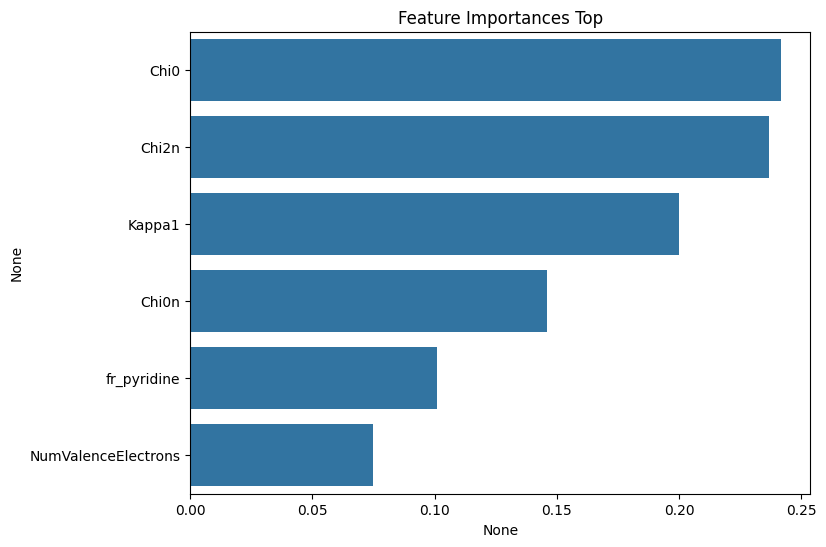

In [9]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top')
sns.barplot(x=top, y=top.index)
plt.show()

### Inference

In [10]:
test = pd.read_csv('./rdkit_test_corr_0.45.csv')

test_y_pred = model.predict(test)

### Submission

In [11]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,28.980108
1,TEST_001,7.416517
2,TEST_002,191.146639
3,TEST_003,7.316443
4,TEST_004,122.283164


In [12]:
submit.to_csv('./corr_0.45_submit.csv', index=False)